In [0]:
!pip install split-folders tqdm

In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from sklearn.metrics import classification_report
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from tensorflow import keras
import tensorflow as tf
import os
import math, numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
import h5py
import glob
import cv2
import zipfile
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import split_folders



Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My Drive/ML - AS1/Dataset2

/content/gdrive/My Drive/ML - AS1/Dataset2


In [0]:
ls

malimg_paper_dataset_imgs/  model.png  output/


In [0]:
base_dir = 'malimg_paper_dataset_imgs'

In [0]:
cur_dir = os.getcwd()

os.chdir(base_dir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [0]:
import matplotlib.pyplot as plt
width_in_inches = 28
height_in_inches = 15
dots_per_inch = 70

plt.figure(
    figsize=(width_in_inches, height_in_inches),
    dpi=dots_per_inch)
plt.plot(list_fams, no_imgs,'^m:', label='Number of dataset')
plt.title('Number of dataset')

plt.figure(figsize=(10, 3))



In [0]:
split_folders.ratio( base_dir, output="output", seed=1337, ratio=(.8, .2)) 

Copying files: 9339 files [2:24:09,  1.38 files/s]


In [0]:
%ls



malimg_paper_dataset_imgs/  model.png  output/


In [0]:
train_dir = os.path.join('output', 'train')
test_dir = os.path.join('output', 'val')
#checkpoint = ModelCheckpoint('weights.{epoch:02d}-{loss:.2f}.hdf5', monitor='loss', save_best_only=True, verbose=1, period=3)
#filepath='/content/gdrive/My Drive/Assignment2/weights.{epoch:02d}-{loss:.2f}.hdf5'
#checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


In [0]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
        
    return X

In [0]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))






out = [0.19716814 0.         1.3561226  2.1713073  0.         1.3324987 ]


In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X


    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (s,s), padding='valid', name = conv_name_base+'1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.09018461 1.2348977  0.46822017 0.0367176  0.         0.655166  ]


In [0]:
def ResNet50(input_shape = (64, 64, 3), classes = 25):
 
    X_input = Input(input_shape)

    
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2,2),name = 'avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model = ResNet50(input_shape = (64, 64, 3), classes = 25)

In [0]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

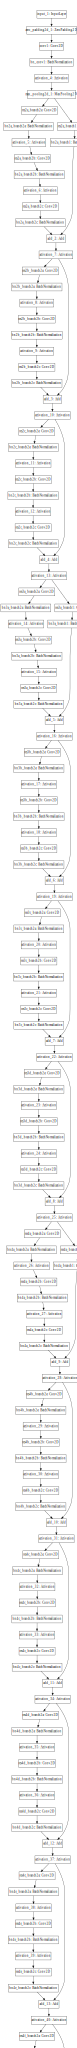

In [0]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(64, 64),  
        batch_size = 128,
        class_mode='categorical')


# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size= 128,
        class_mode='categorical')

Found 7459 images belonging to 25 classes.
Found 1880 images belonging to 25 classes.


In [0]:

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)


Epoch 1/20
 - 131s - loss: 0.1242 - acc: 0.9601 - val_loss: 0.2142 - val_acc: 0.9349
Epoch 2/20
 - 127s - loss: 0.0379 - acc: 0.9883 - val_loss: 0.1897 - val_acc: 0.9567
Epoch 3/20
 - 128s - loss: 0.0235 - acc: 0.9923 - val_loss: 0.1105 - val_acc: 0.9694
Epoch 4/20
 - 126s - loss: 0.0141 - acc: 0.9961 - val_loss: 0.1394 - val_acc: 0.9621
Epoch 5/20
 - 125s - loss: 0.0298 - acc: 0.9926 - val_loss: 8.8419 - val_acc: 0.1067
Epoch 6/20
 - 129s - loss: 0.0258 - acc: 0.9950 - val_loss: 0.1007 - val_acc: 0.9752
Epoch 7/20
 - 125s - loss: 0.0138 - acc: 0.9968 - val_loss: 0.1660 - val_acc: 0.9662
Epoch 8/20
 - 125s - loss: 0.1670 - acc: 0.9850 - val_loss: 0.3133 - val_acc: 0.9570
Epoch 9/20
 - 126s - loss: 0.1901 - acc: 0.9857 - val_loss: 0.4046 - val_acc: 0.9369
Epoch 10/20
 - 123s - loss: 0.1903 - acc: 0.9881 - val_loss: 0.3040 - val_acc: 0.9712
Epoch 11/20
 - 128s - loss: 0.2532 - acc: 0.9525 - val_loss: 15.4504 - val_acc: 0.0409
Epoch 12/20
 - 127s - loss: 0.2312 - acc: 0.9414 - val_loss: 9

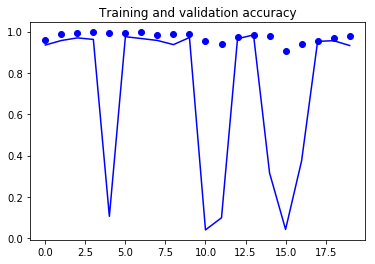

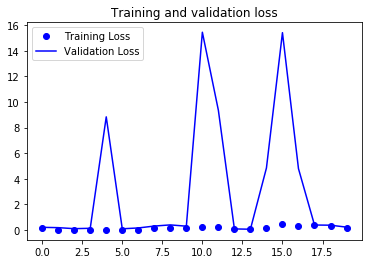

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
loss, acc = model_last.evaluate_generator(test_generator, steps=140)
print("\n%s: %.2f%%" % (model_last.metrics_names[1], acc * 100))


acc: 96.47%
